In [3]:
from __future__ import division

import numpy as np
import matplotlib.pyplot as plt

import warnings

warnings.filterwarnings('ignore')

%matplotlib inline
%load_ext autoreload
%autoreload 2

plotp = lambda x, col: plt.scatter(x[0, :], x[1, :], s=200, edgecolors="k", c=col, linewidths=2)

In [4]:
N = [220, 200]
d = 2
x = np.random.rand(2, N[0]) - .5
p = 0.5
y_0 = 2 * np.random.rand(1, N[1]) - 1
r = .8 + .2 * np.random.rand(1, N[1])
y1_sign = 2 * (np.random.rand(1, N[1]) > .5) - 1
y = np.vstack((y_0, y1_sign * (r ** p - (np.abs(y_0)) ** p) ** (1 / p)))

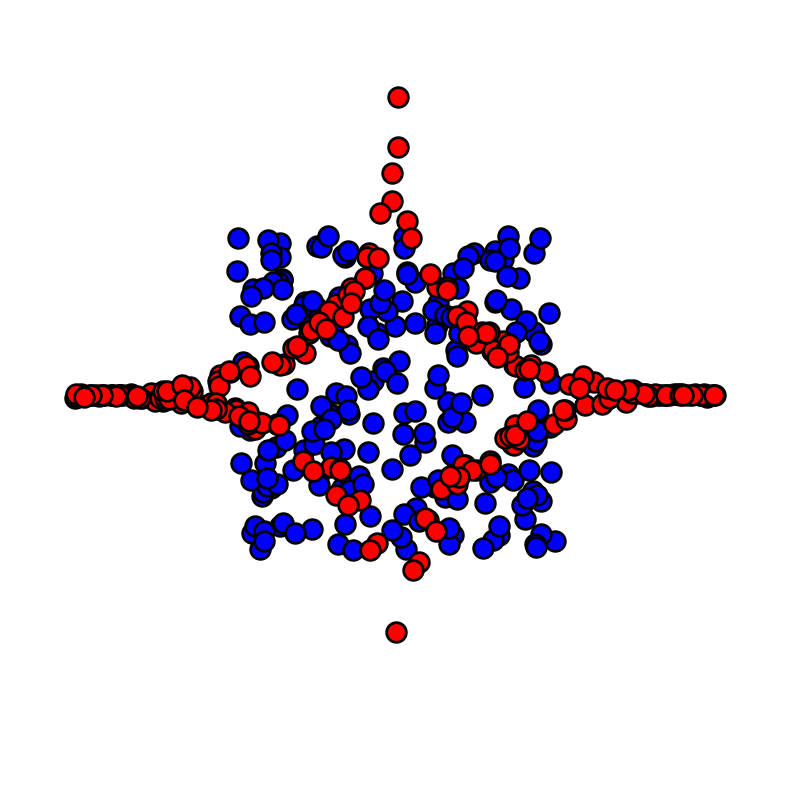

In [5]:
plt.figure(figsize=(10, 10))
plt.xlim(-1.2, 1.2)
plt.ylim(-1.2, 1.2)
plotp(x, 'b')
plotp(y, 'r')

plt.axis("off")

plt.show()

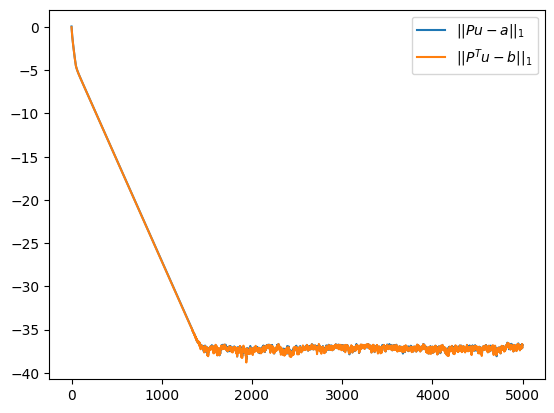

In [6]:
x2 = np.sum(x ** 2, 0)
y2 = np.sum(y ** 2, 0)
C = np.tile(y2, (N[0], 1)) + np.tile(x2[:, np.newaxis], (1, N[1])) - 2 * np.dot(np.transpose(x), y)

a = np.ones(N[0]) / N[0]
b = np.ones(N[1]) / N[1]

epsilon = .01;

K = np.exp(-C / epsilon)

init_v = np.ones(N[1])
v = init_v

def sinkhorn(K, a, b, init_v, tol=-40, max_iter=5000):
    """
    Sinkhorn Algorithm
    """
    k = 0
    v = init_v
    err = np.linalg.norm(v * (K.T @ np.ones(K.shape[0])) - b, ord=1)
    viols_1 = np.empty(max_iter)
    viols_2 = np.empty(max_iter)
    while (k < max_iter) & (np.log(err) > tol):
        u = a / (np.dot(K, v))
        viol_1 = np.linalg.norm(v * (K.T @ u) - b, ord=1)
        v = b / (np.dot(np.transpose(K), u))
        viol_2 = np.linalg.norm(u * (K @ v) - a, ord=1)
        err = max(viol_1, viol_2)
        viols_1[k] = viol_1
        viols_2[k] = viol_2
        k += 1

    ot = u[:, None] * K * v[None, :]
    return ot, u, v, viols_1[:k], viols_2[:k]


ot, u, v, viols1, viols2 = sinkhorn(K=K, a=a, b=b, init_v=init_v)
plt.plot(np.log(viols1), label="$||Pu-a||_1$")
plt.plot(np.log(viols2), label="$||P^Tu-b||_1$")
plt.legend()
plt.savefig("violation.png")

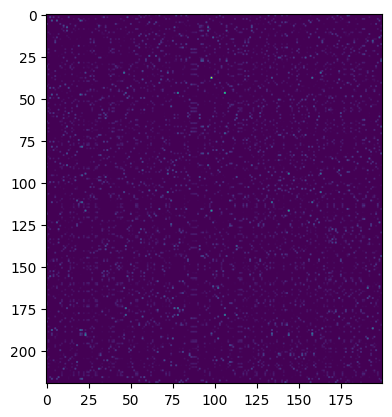

In [7]:
P = ot
plt.imshow(P);

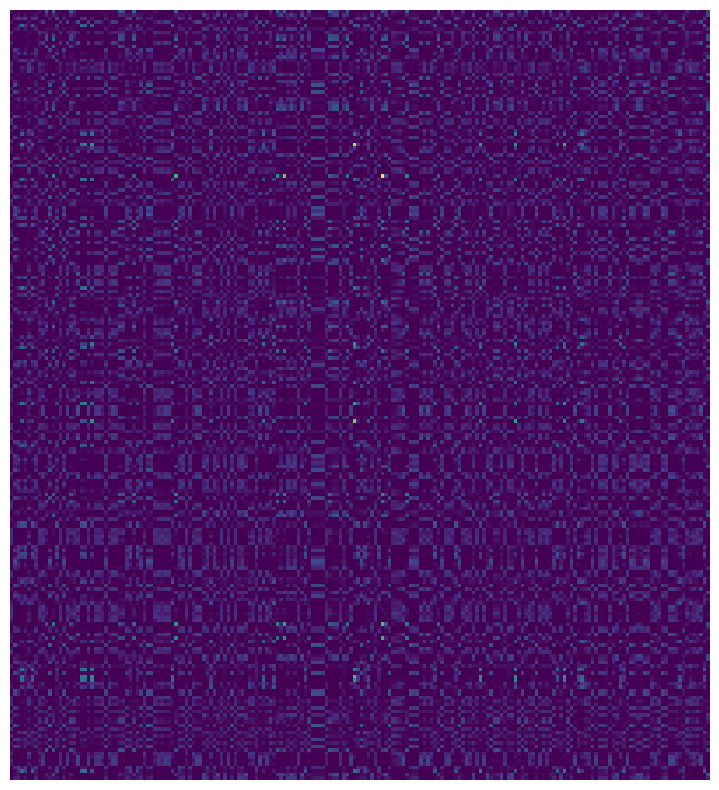

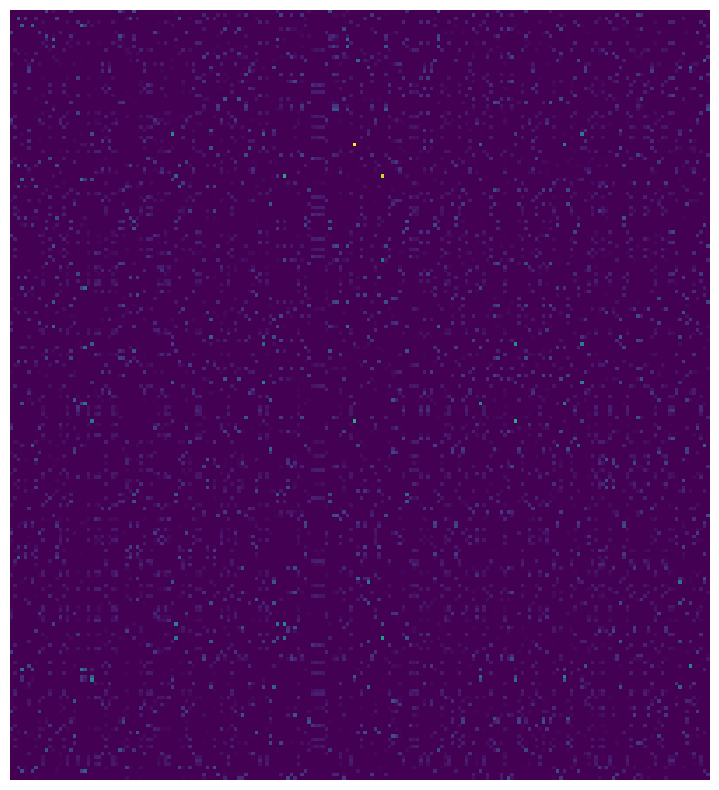

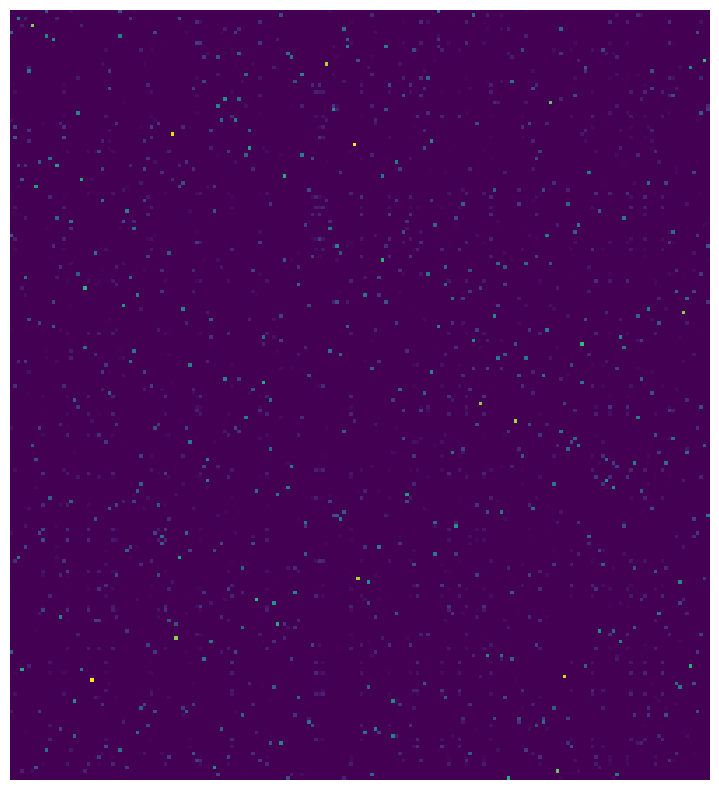

In [8]:
epss = [.1, .01, .001]
for i, eps in enumerate(epss):
    K = np.exp(-C / eps)
    ot, _, _, _, _ = sinkhorn(K=K, a=a, b=b, init_v=init_v)
    P = ot
    plt.figure(figsize=(10, 10))
    plt.axis("off")
    plt.imshow(P)
    plt.savefig("log_plan_epsilon_{}.png".format(eps))

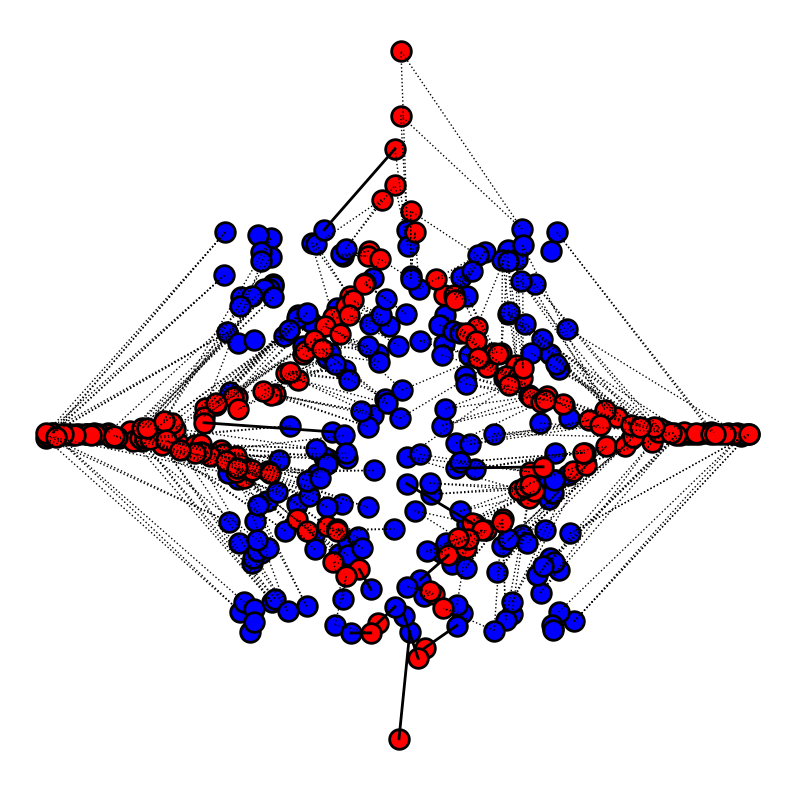

In [9]:
plt.figure(figsize=(10, 10))

plotp(x, 'b')
plotp(y, 'r')

A = P * (P > np.max(P) * .8)
i, j = np.where(A != 0)
plt.plot([x[0, i], y[0, j]], [x[1, i], y[1, j]], 'k', lw=2)

A = P * (P > np.max(P) * .2)
i, j = np.where(A != 0)
plt.plot([x[0, i], y[0, j]], [x[1, i], y[1, j]], 'k:', lw=1)

plt.axis("off")
plt.xlim(np.min(y[0, :]) - .1, np.max(y[0, :]) + .1)
plt.ylim(np.min(y[1, :]) - .1, np.max(y[1, :]) + .1)

plt.show()

In [10]:
N = 200
t = np.arange(0, N) / N
Laplace = lambda t0, sigma: np.exp(-np.abs(t - t0) / (2 * sigma ** 2))
Gaussian = lambda t0, sigma: np.exp(-(t - t0) ** 2 / (2 * sigma ** 2))
normalize = lambda p: p / np.sum(p)

sigma = .06;
a = Laplace(.25 , sigma * 2)
b = Gaussian(.8, sigma)

vmin = .02;
a = normalize(a + np.max(a) * vmin)
b = normalize(b + np.max(b) * vmin)

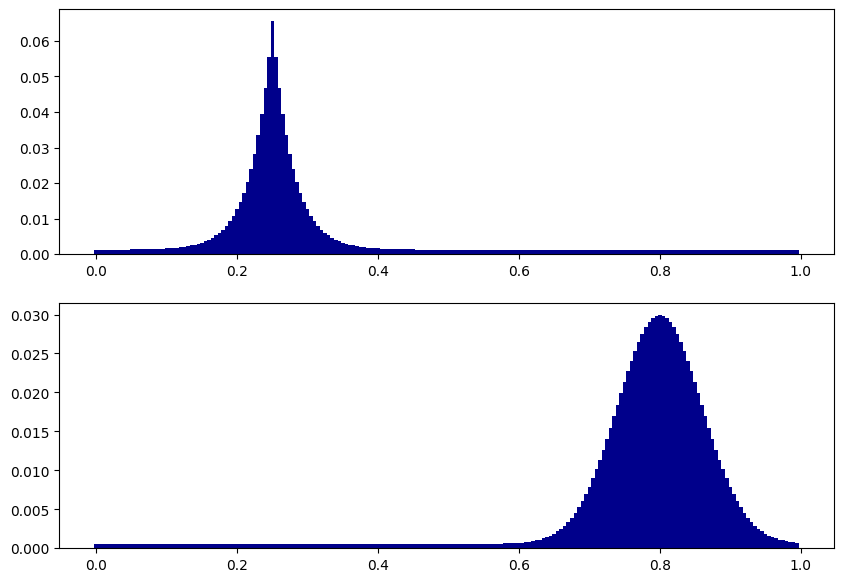

In [11]:
plt.figure(figsize=(10, 7))

plt.subplot(2, 1, 1)
plt.bar(t, a, width=1 / len(t), color="darkblue")
plt.subplot(2, 1, 2)
plt.bar(t, b, width=1 / len(t), color="darkblue")

plt.show()

In [12]:
epsilon = (.03) ** 2
[Y, X] = np.meshgrid(t, t)
K = np.exp(-(X - Y) ** 2 / epsilon)

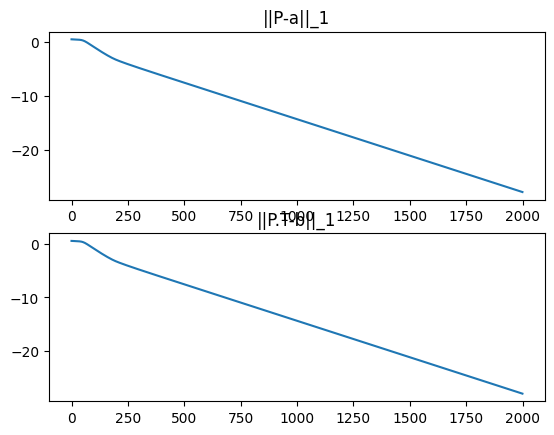

In [13]:

ot, u, v, viols1, viols2 = sinkhorn(K=K, a=a, b=b, init_v=init_v, max_iter=2000)
plt.subplot(2, 1, 1)
plt.title("||P-a||_1")
plt.plot(np.log(viols1))
plt.subplot(2, 1, 2)
plt.title("||P.T-b||_1")
plt.plot(np.log(viols2))

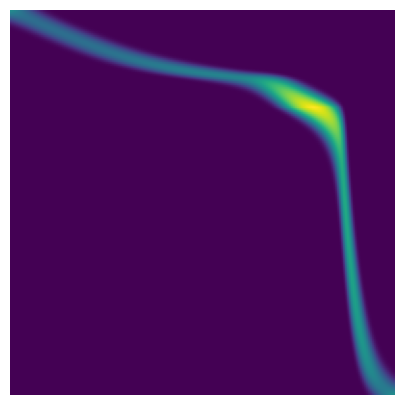

In [14]:
P = ot
plt.figure(figsize=(5, 5))
plt.imshow(np.log(P + 1e-5))
plt.axis('off');

In [15]:
s = np.dot(K, v * t) * u / a

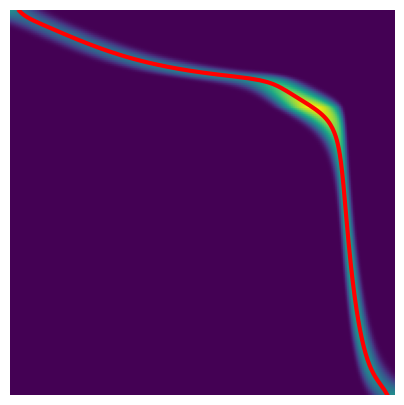

In [16]:
plt.figure(figsize=(5, 5))
plt.imshow(np.log(P + 1e-5))
plt.plot(s * N, t * N, 'r', linewidth=3);
plt.axis('off');

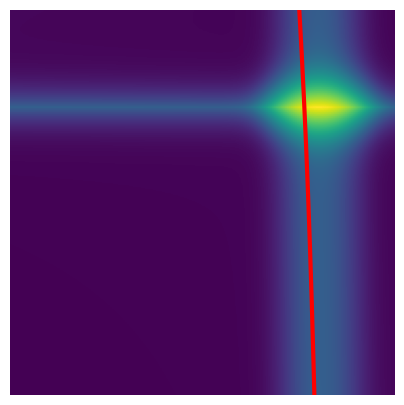

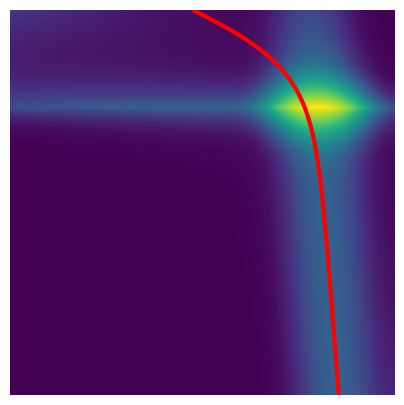

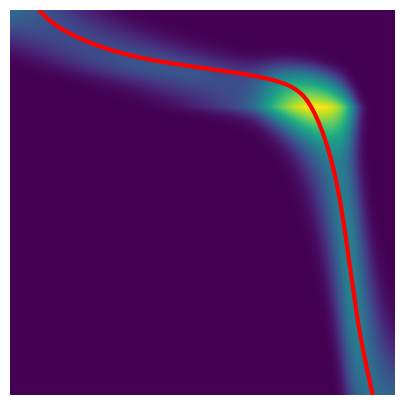

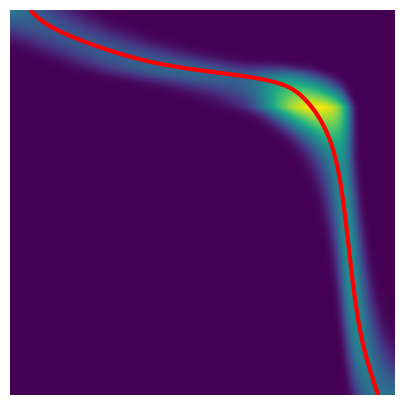

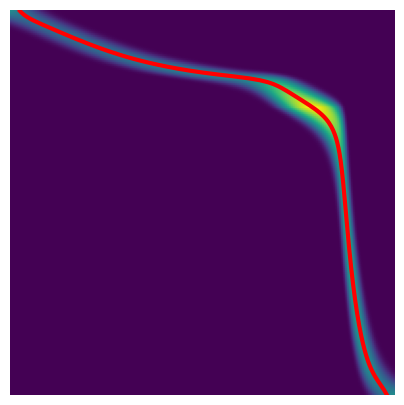

In [17]:
epss = [1.0, .1, .01, 0.005, .001]
for i, eps in enumerate(epss):
    K = np.exp(-(X - Y) ** 2 / eps)
    ot, u, v, _, _ = sinkhorn(K=K, a=a, b=b, init_v=init_v, max_iter=2000)
    P = ot
    s = np.dot(K, v * t) * u / a
    plt.figure(figsize=(5, 5))
    plt.imshow(np.log(P + 1e-5))
    plt.plot(s * N, t * N, 'r', linewidth=3)
    plt.axis('off');
    plt.savefig("log_transport_plan_epsilon_{}.png".format(eps))

In [81]:
import torch

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

epsilon = (.06) ** 2
K = np.exp(-(X - Y) ** 2 / epsilon)

u = torch.ones(N);
v = torch.ones(N);
K1 = torch.from_numpy(K).type(torch.FloatTensor);
a1 = torch.from_numpy(a).type(torch.FloatTensor);
b1 = torch.from_numpy(b).type(torch.FloatTensor);
# send them to the GPU
K1 = K1.to(device);
u = u.to(device);
v = v.to(device);
a1 = a1.to(device);
b1 = b1.to(device);


def sinkhorn_torch(K1, a1, b1, init_v, niter=2000):
    """
    Sinkhorn Algorithm using Torch
    """
    v = init_v
    Err_p = torch.zeros(niter)
    Err_q = torch.zeros(niter)
    for i in range(niter):
        # sinkhorn step 1
        u = a1 / (K1 * v[None, :]).sum(1)
        # error computation
        r = v * (K1 * u[:, None]).sum(0)
        Err_q[i] = torch.norm(r - b1, p=1)
        # sinkhorn step 2
        v = b1 / (K1 * u[:, None]).sum(0)
        s = u * (K1 * v[None, :]).sum(1)
        Err_p[i] = torch.norm(s - a1, p=1)

    ot = u[:, None] * K * v[None, :]
    return ot, u, v, Err_q, Err_p

cpu


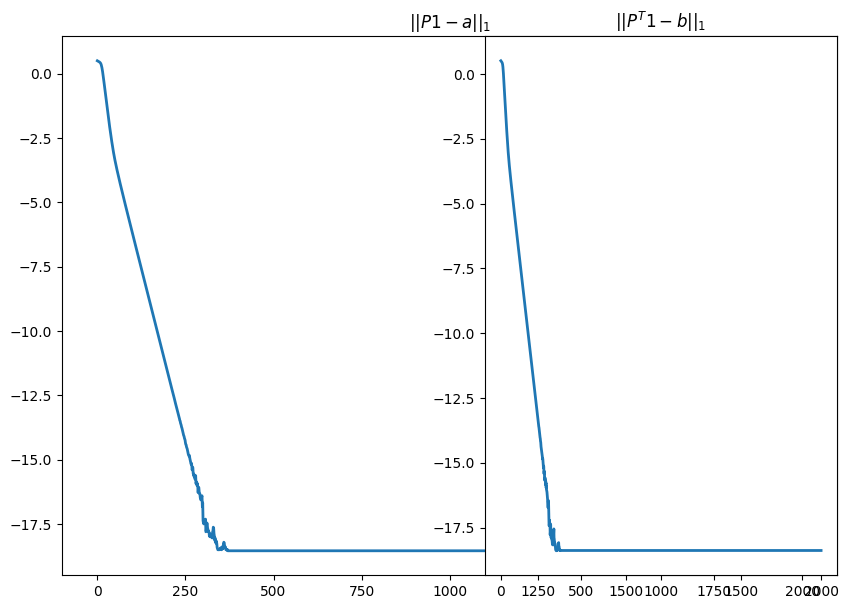

In [82]:
init_v = torch.ones(N)
niter = 2000
ot, u, v, Err_q, Err_p = sinkhorn_torch(K1, a1, b1, init_v, niter=niter)
plt.figure(figsize=(10, 7))
plt.subplot(1, 1, 1)
plt.title("$||P1 -a||_1$")
plt.plot(np.log(np.asarray(Err_p)), linewidth=2)
plt.subplot(1, 2, 2)
plt.title("$||P^T 1 -b||_1$")
plt.plot(np.log(np.asarray(Err_q)), linewidth=2)
plt.show()

In [2]:
def sinkhorn_torch_log(K1, a1, b1, init_v, niter=2000):
    """
    Sinkhorn Algorithm in a log-sum-exp style, using Torch
    """
    log_v = torch.log(init_v)
    Err_p = torch.zeros(niter)
    Err_q = torch.zeros(niter)
    cost_over_reg = torch.log(K1)
    log_a1 = torch.log(a1)
    log_b1 = torch.log(b1)
    for i in range(niter):
        # sinkhorn step 1
        _log_denominator_u = cost_over_reg + log_v[None, :]
        log_denominator_u = torch.logsumexp(_log_denominator_u, dim=1, keepdim=False)
        log_u = log_a1 - log_denominator_u
        # error computation
        _ = cost_over_reg + log_u[:, None]

        log_r = log_v + torch.logsumexp(_, dim=0, keepdim=False)
        Err_q[i] = torch.norm(np.exp(log_r) - b1, p=1)
        # sinkhorn step 2
        _log_denominator_v = cost_over_reg + log_u[:, None]
        log_denominator_v = torch.logsumexp(_log_denominator_v, dim=0, keepdim=False)
        log_v = log_b1 - log_denominator_v
        # error computation
        _ = cost_over_reg + log_v[None, :]
        log_s = log_u + torch.logsumexp(_, dim=1, keepdim=False)
        Err_p[i] = torch.norm(np.exp(log_s) - a1, p=1)

    ot = log_u[:, None] + cost_over_reg + log_v[None, :]
    ot = np.exp(ot)
    return ot, u, v, Err_q, Err_p

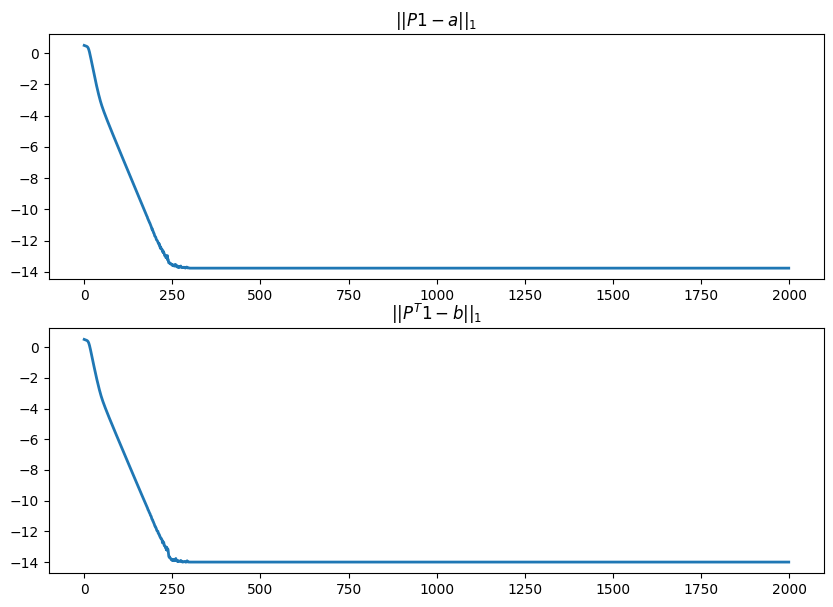

In [84]:
init_v = torch.ones(N)
niter = 2000
ot, u, v, Err_q, Err_p = sinkhorn_torch_log(K1, a1, b1, init_v, niter=niter)
plt.figure(figsize=(10, 7))
plt.subplot(2, 1, 1)
plt.title("$||P1 -a||_1$")
plt.plot(np.log(np.asarray(Err_p)), linewidth=2)
plt.subplot(2, 1, 2)
plt.title("$||P^T 1 -b||_1$")
plt.plot(np.log(np.asarray(Err_q)), linewidth=2)
plt.show()

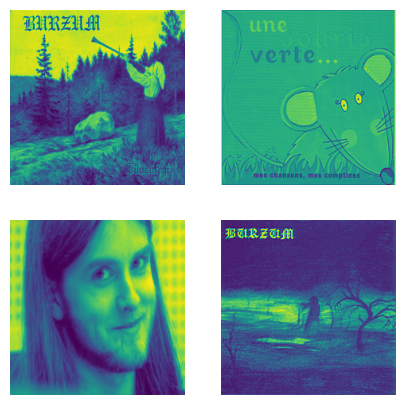

In [13]:
N, M = 220, 220
import imageio

rescale = lambda x: (x - x.min()) / (x.max() - x.min())
names = ['filosofem.bmp', 'green.bmp', 'varg.bmp', '1992.bmp']
vmin = .01
A = np.zeros([N, M, len(names)])
for i in range(len(names)):
    a = imageio.imread(names[i])  # ,N)
    a = normalize(rescale(a) + vmin)
    A[:, :, i] = a
R = len(names)
plt.figure(figsize=(5, 5))
for i in range(R):
    plt.subplot(2, 2, i + 1)
    plt.imshow(A[:, :, i])
    plt.axis('off');

epsilon = (.04) ** 2

t = np.linspace(0, 1, N)
[Y, X] = np.meshgrid(t, t)
K1 = np.exp(-(X - Y) ** 2 / epsilon)
K = lambda x: np.dot(np.dot(K1, x), K1)

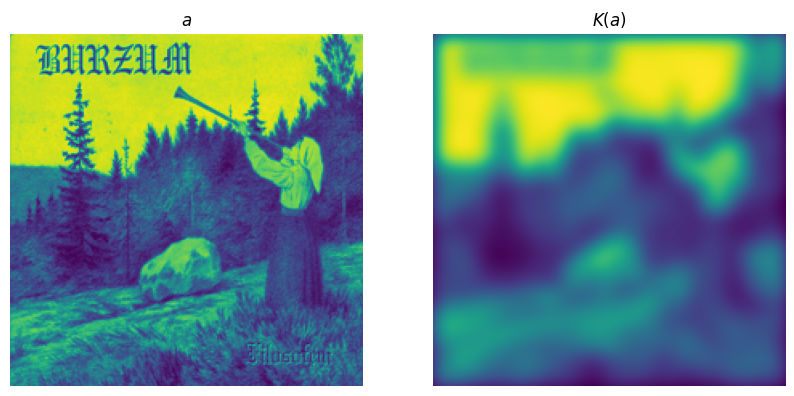

In [14]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(A[:, :, 0])
plt.title("$a$")
plt.axis('off');
plt.subplot(1, 2, 2)
plt.imshow(K(A[:, :, 0]))
plt.title("$K(a)$")
plt.axis('off');

In [15]:
lambd = np.ones(R) / R
v = np.ones([N, M, R])
u = np.copy(v)

In [16]:
def iso_barycenter_sinkhorn(A, K, lambd, n_iter=100):
    N, R = A.shape[0], A.shape[-1]
    v = np.ones([N, M, R])
    u = np.copy(v)
    err = np.zeros(n_iter)
    for i in range(n_iter):
        for k in range(R):
            err[i] += np.linalg.norm(u[:, :, k] * K(v[:, :, k]) - A[:, :, k], ord=1)
            u[:, :, k] = A[:, :, k] / K(v[:, :, k])
        b = np.zeros(N)
        for k in range(R):
            b = b + lambd[k] * np.log(np.maximum(1e-19 * np.ones(len(v[:, :, k])), v[:, :, k] * K(u[:, :, k])))
        b = np.exp(b)
        for k in range(R):
            v[:, :, k] = b / K(u[:, :, k])
    return b, u, v, err

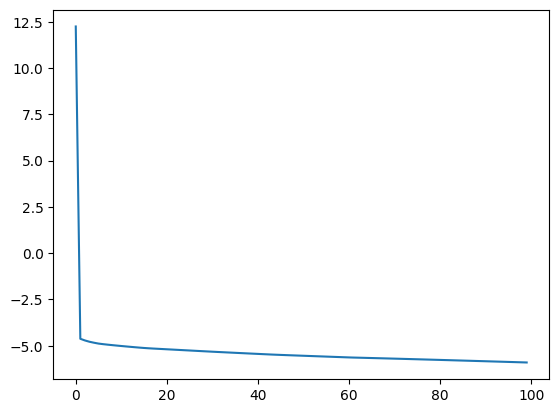

In [17]:
b, _, _, err = iso_barycenter_sinkhorn(A, K, lambd)
plt.plot(np.log(err))

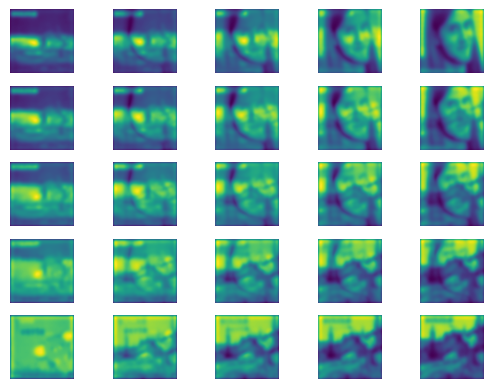

In [18]:
m = 5
[T, S] = np.meshgrid(np.linspace(0, 1, m), np.linspace(0, 1, m))
T = np.ravel(T, order="F")
S = np.ravel(S, order="F")
for j in range(m ** 2):
    lambd = np.hstack((S[j] * T[j], (1 - S[j]) * T[j], S[j] * (1 - T[j]), (1 - S[j]) * (1 - T[j])))
    b, _, _, err = iso_barycenter_sinkhorn(A, K, lambd, n_iter=100)
    plt.subplot(m, m, j + 1)
    plt.imshow(b)
    plt.axis('off')